In [4]:
import numpy as np
import pandas as pd
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split 
from keras.layers import Embedding, Dense, LSTM, Dropout, GRU, Bidirectional
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

In [5]:
# to fetch the cleaned text data from google drive 
textdata_df = pd.read_csv('/content/drive/MyDrive/text_mining_project/naturalscience/attempt2.csv') 

textdata_df = textdata_df.dropna(how="any")

textdata = textdata_df['cleaned_Comments'].tolist()

Yresult = textdata_df['Topic'].tolist( ) 
Y = [] 
for y in Yresult: 
  if y == 'Biology': 
    Y.append(-1)
  if y == 'Physics': 
    Y.append(0)
  if y == 'Chemistry':
    Y.append(1)

In [6]:
class Newdf:
  def __init__(self, inputdf): 
    # to create an input dataset for classification with a neural network 
    self.df = inputdf.dropna(how="any") 

  def uniquelist(self): 
    """
    output: vocabulary to index 
    """
    # max number of words in a sentence 
    max_len = 400

    # to store the cleaned and digitalised data 
    self.blogpostdigits = [ ]
    self.topics = [ ]

    # to create an empty dictionary to store the index of each word
    vocabulary = {}
    vocabulary["<sos>"] = 1
    vocabulary["<eos>"] = 2

    textdata = self.df['cleaned_Comments'].tolist() 
    Yresult = self.df['Topic'].tolist( )  

    i = 0

    for text in textdata: 
      newlist = text.split() 
      textlist = [ ]
      for Char in newlist: 
        if vocabulary.get(Char) is None:
          vocabulary[Char] = len(vocabulary)+1 
        textlist.append(vocabulary.get(Char))

      # to count the number of words in each blog post     
      L = len(newlist)  
      if L < 2: 
        continue
      if L > max_len: 
        textlist = textlist[0:max_len]
      # zero paddings 
      pad = [0]*max_len
      # To replace the actual words, at the end of the list containing only zeros 
      pad[-len(textlist):] = textlist 
      # to add one more chunk of text 
      self.blogpostdigits.append(pad) 

      if Yresult[i] == 'Biology':
        self.topics.append(-1)
      if Yresult[i] == 'Physics':
        self.topics.append(0) 
      if Yresult[i] == 'Chemistry':
        self.topics.append(1)
      
      i += 1

    self.vocabulary = vocabulary
    self.max_len = max_len 

In [7]:
model1 = Newdf(textdata_df)
model1.uniquelist( )

In [8]:
vocabulary = model1.vocabulary
max_len = model1.max_len 

X = model1.blogpostdigits
y = model1.topics 

In [15]:
# to collect a list of unique words 
uniquewords = [ ]

for text in textdata: 
  newlist = text.split() 
  for Char in newlist: 
    if Char not in uniquewords:
      uniquewords.append(Char)

values = array(uniquewords)

# to create an empty dictionary to store the index of each word 
vocabulary = {}
vocabulary["<sos>"] = 1
vocabulary["<eos>"] = 2

In [20]:
# max number of words in a sentence 
max_len = 400
wordindex = []  
for word in uniquewords:
  if vocabulary.get(word) is None:
    vocabulary[word] = len(vocabulary)+1
  



16589

In [23]:
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

[14959 16520  9359 ...  2644  1904 16399]


In [11]:
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded) 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:

model3 = Sequential()
###Add layers here
#Embedding
model3.add(Embedding(input_dim= len(vocabulary)+1, output_dim=100, input_length=max_len))
#Dense
model3.add(Dense(units=256, activation = "tanh"))
#Dropout
model3.add(Dropout(rate=0.2)) 
# one dimensional CNN
model3.add(Conv1D(128, 7, padding="valid", activation="tanh", strides=3)) 
model3.add(Conv1D(64, 7, padding="valid", activation="tanh", strides=3))  
# max pooling
#model3.add(GlobalMaxPooling1D())
# one dimensional CNN
model3.add(Conv1D(64, 7, padding="valid", activation="tanh", strides=3))  
model3.add(Conv1D(128, 7, padding="valid", activation="tanh", strides=3)) 
model3.add(GlobalMaxPooling1D())
#Dense 
model3.add(Dense(units=256, activation = "tanh"))
#Dropout
model3.add(Dropout(rate=0.2))
#Dense
model3.add(Dense(units=512, activation="tanh"))
#Dense 
model3.add(Dense(units=256, activation = "tanh"))
#Dense
model3.add(Dropout(rate=0.2))
#Dense
model3.add(Dense(units=1, activation="sigmoid" ))

model3.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 100)          1659200   
                                                                 
 dense (Dense)               (None, 400, 256)          25856     
                                                                 
 dropout (Dropout)           (None, 400, 256)          0         
                                                                 
 conv1d (Conv1D)             (None, 132, 128)          229504    
                                                                 
 conv1d_1 (Conv1D)           (None, 42, 64)            57408     
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 64)            28736     
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 128)            5

In [10]:
X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, test_size=0.15, shuffle=True)

In [11]:
history = model3.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=64, epochs= 5, verbose= 4)


Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


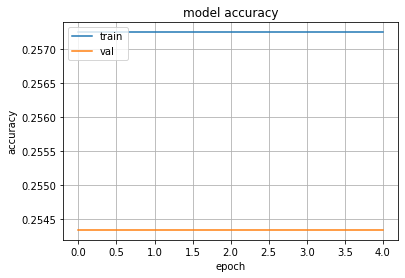

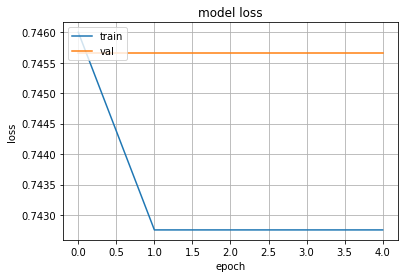

In [12]:
def plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid(True)
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid(True)
    plt.show()

plot(history)

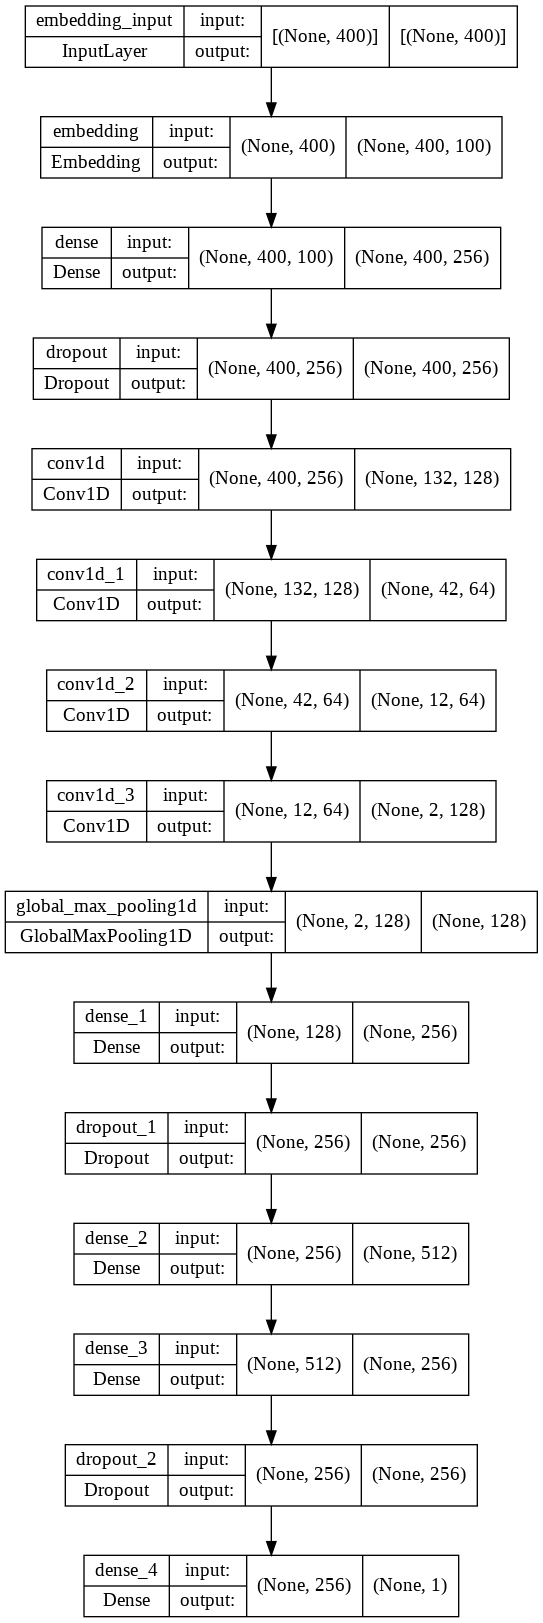

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(model3, "model.png", show_shapes=True) 

In [14]:
def metrics(model, X_test, y_test):
    predictions = model.predict(X_test)    

    predictions = np.rint(predictions)

    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test, predictions).ravel())

metrics(model3, X_test, y_test)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       782
           0       0.24      1.00      0.39       467
           1       0.00      0.00      0.00       670

    accuracy                           0.24      1919
   macro avg       0.08      0.33      0.13      1919
weighted avg       0.06      0.24      0.10      1919

[  0 782   0   0 467   0   0 670   0]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
model2 = Sequential()
###Add layers here
#Embedding
model2.add(Embedding(input_dim= len(vocabulary)+1, output_dim=100, input_length=max_len))
model2.add(Bidirectional(LSTM(64, return_sequences=True))) 
model2.add(Bidirectional(LSTM(64)) )
#Dense
model2.add(Dense(units=256, activation = "relu"))
#Dropout
model2.add(Dropout(rate=0.2))
#Dense
model2.add(Dense(units=512, activation="relu"))
#Dense
model2.add(Dense(units=1, activation="sigmoid" ))

model2.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model2.summary()



history = model2.fit(X_train, y_train,validation_data = (X_val, y_val), batch_size=64, epochs=4, verbose=1)
#plot(history)
metrics(model2, X_test, y_test)  

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 400, 100)          1659200   
                                                                 
 bidirectional (Bidirectiona  (None, 400, 128)         84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 512)              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


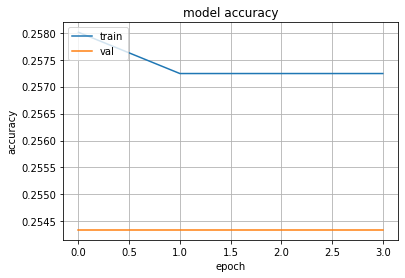

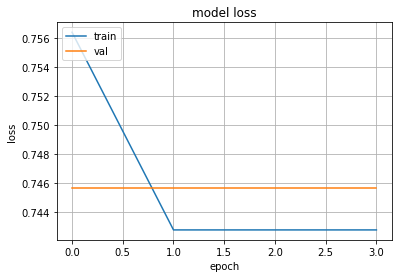

In [18]:
plot(history)

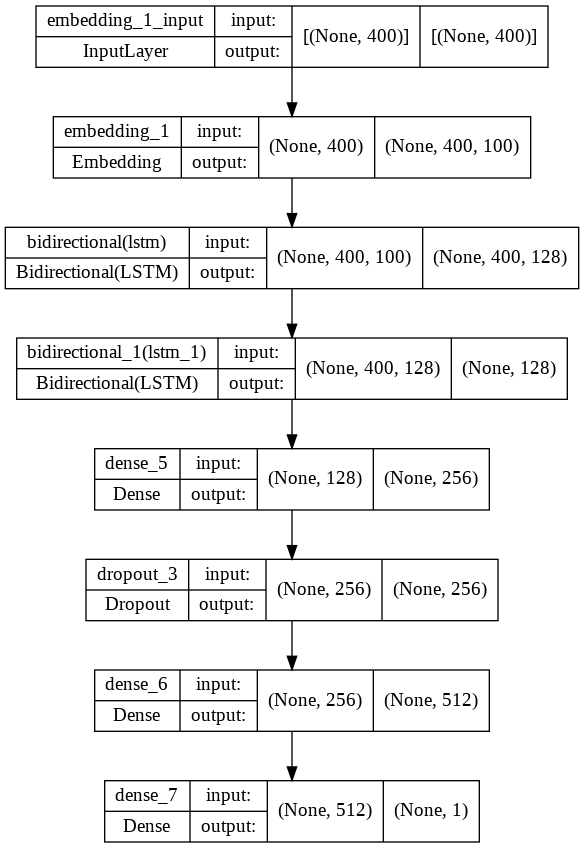

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(model2, "model.png", show_shapes=True) 